In [8]:
%load_ext autoreload
%autoreload 2

# SLIP

## a Simple Library for Image Processing


Table of content

* [What is the SLIP package?](#What-is-the-SLIP-package?) 
* [Installing](#Install) 
* [Importing the library](#Importing-the-library)
* [Filtering](#Filtering) 
* [Whitening](#Whitening) 
* [Handling a database](#Handling-a-database)
* [An application: statistics of natural images](#An-application:-statistics-of-natural-images)


## What is the SLIP package?

The ``SLIP`` library defines a simple object-oriented class for gray-scale image processing. Use it to create a SLIP object with a dedicated image size (and optionnaly some other useful parameters) - which you can use to apply common image processing routines to your images.

In [9]:
from SLIP import Image
im = Image()
print(im.__doc__)


    This library collects different Image Processing tools.

    Fork me on https://github.com/meduz/SLIP !

    This library is used in other projects, in particular  for use with the ``LogGabor`` and ``SparseEdges`` libraries
    For more information check respective pages @ 
        - http://pythonhosted.org/LogGabor and 
        - http://pythonhosted.org/SparseEdges

    Collects image processing routines for one given image size:
     - Some classical related to pure Fourier number crunching:
        - creating masks
        - normalize,
        - fourier_grid : defines a useful grid for generating filters in FFT
        - show_FT : displays the envelope and impulse response of a filter
        - invert : go to the other of the fourier transform
    - Some usual application of Fourier filtering:
        - trans : translation filter in Fourier space
        - whitening procedures
     - Some related to handling experiments:
        - load_in_database : loads a random image in a fo

[Back to top](#SLIP)

## Installing

Requirements :

* numpy
* scipy
* NeuroTools
* ipython
* matplotlib

To install them, use

    pip install -U -r requirements.txt
    
Install using pip:

    pip install -U SLIP

In [10]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)
fopts = {'fontsize':18}
opts= {'cmap': plt.cm.gray, 'vmin':-1., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}

[Back to top](#SLIP)

## Importing the library

In [11]:
im = Image({'N_X':128, 'N_Y':128})
print(im.__init__.__doc__)


        Initializes the Image class

        May take as input:

        - a dictionary containing parameters 
        - a string pointing to  a file or URL containing a dictionary of parameters 
        - a ``NeuroTools.parameters.ParameterSet`` object containing parameters 

        Parameters are 

        - N_X and N_Y which are respectively the number of pixels in the vertical and horizontal dimensions respectively (MANDATORY)
        - optional parameters which are used in the various functions such as N_image when handling a database or the whitening parameters.

        


[Back to top](#SLIP)

## Filtering

In [12]:
print(im.FTfilter.__doc__)


        Using the ``FTfilter`` function, it is easy to filter an image with a filter defined in Fourier space.

        


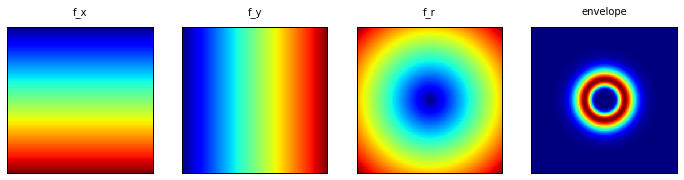

In [13]:
from SLIP import Image
sf_0 = 0.15
B_sf = 0.05
theta_0 = np.pi/2
B_theta = 0.15
loggabor = True

def envelope_orientation(im, theta_0=theta_0, B_theta=B_theta, norm=True):
    theta = np.arctan2(im.f_x, im.f_y)
    env =  np.exp(np.cos(2*(theta-theta_0))/B_theta**2)
    if norm: env /= np.sqrt((env**2).sum())
    return env

def envelope_radial(im, sf_0=sf_0, B_sf=B_sf, loggabor=loggabor, norm=True):
    if sf_0 == 0.: return 1.
    if loggabor:
        env = 1./im.f*np.exp(-.5*(np.log(im.f/sf_0)**2)/(np.log((sf_0+B_sf)/sf_0)**2))
        if norm: env /= np.sqrt((env**2).sum())
        return env
    else:
        return np.exp(-.5*(im.f - sf_0)**2/B_sf**2)

im = Image('default_param.py')
env = envelope_radial(im)

fig, ax = plt.subplots(1, 4, figsize=figsize)
for i, (f, label) in enumerate(zip([im.f_x, im.f_y, im.f, env], ['f_x', 'f_y', 'f_r', 'envelope'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

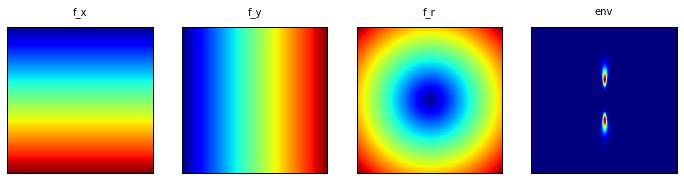

In [14]:
env = envelope_radial(im) * envelope_orientation(im)

fig, ax = plt.subplots(1, 4, figsize=figsize)
for i, (f, label) in enumerate(zip([im.f_x, im.f_y, im.f, env], ['f_x', 'f_y', 'f_r', 'env'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

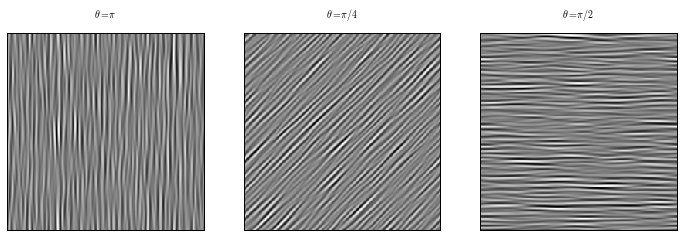

In [15]:
# one can then easily generate a texture
theta0 = np.pi/2
Btheta = 0.15
theta_0 = [0, np.pi/4, np.pi/2]
B_theta = [0.1, 0.5, 1.]

def texture(env):
 return np.fft.fft2(np.fft.ifftshift(env * np.exp(1j * 2 * np.pi * np.random.rand(env.shape[0], env.shape[1])))).real

def impulse(env, phi=2 * np.pi):
    I = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(env * np.exp(1j * phi))).real)
    I /= env.sum()
    return I

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (theta0_, label) in enumerate(zip(theta_0, [r'$\theta = \pi$', r'$\theta = \pi/4$', r'$\theta = \pi/2$']) ) :
    env = envelope_radial(im) * envelope_orientation(im, theta_0=theta0_, B_theta=Btheta)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#plt.tight_layout()
fig.savefig('figures/realisation_MC_theta0(week4).pdf')

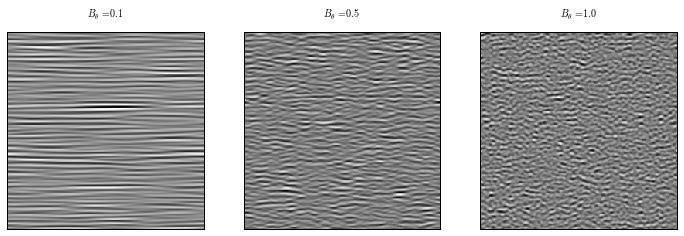

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (Btheta_, label) in enumerate(zip(B_theta, [r'$B_\theta = 0.1$', r'$B_\theta = 0.5$', r'$B_\theta = 1.0$']) ) :
    env = envelope_radial(im) * envelope_orientation(im, theta_0=theta0, B_theta=Btheta_)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#plt.title(u'Réalisation du Motion Clouds')
#plt.tight_layout()
fig.savefig('figures/realisation_MC_Btheta(week4).pdf')

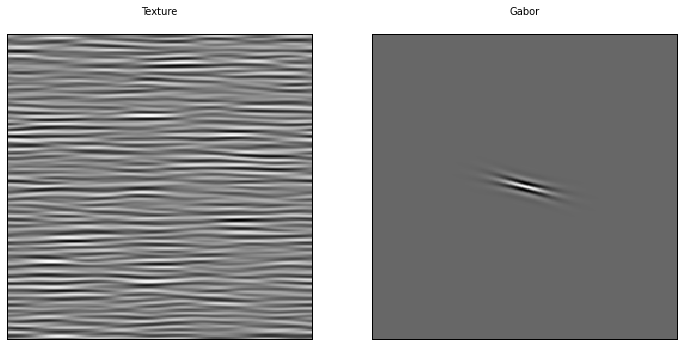

In [17]:
env_in = envelope_radial(im) * envelope_orientation(im)
env_V1 = envelope_radial(im) * envelope_orientation(im, theta_0=np.random.rand()*np.pi)

fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1)], [u'Texture', u'Gabor'])):
    ax[i].matshow(f, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])    

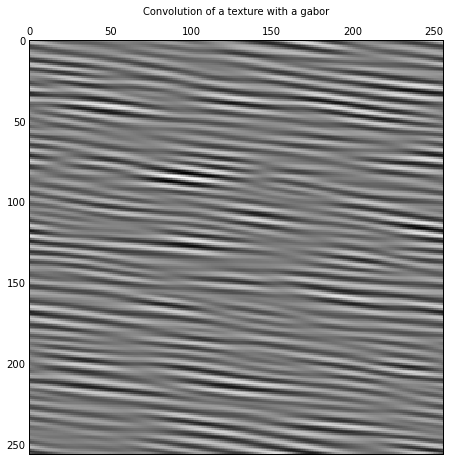

In [18]:
def convolve(image_in, image_V1):
    env_in = np.fft.fft2(image_in)
    env_V1 = np.fft.fft2(image_V1)
    return np.fft.fftshift(np.fft.ifft2((env_in*env_V1)).real)

R = convolve(texture(env_in), impulse(env_V1))
fig, ax = plt.subplots(figsize=figsize)
ax.matshow(R, cmap=plt.cm.gray)
plt.title(u"Convolution of a texture with a gabor")

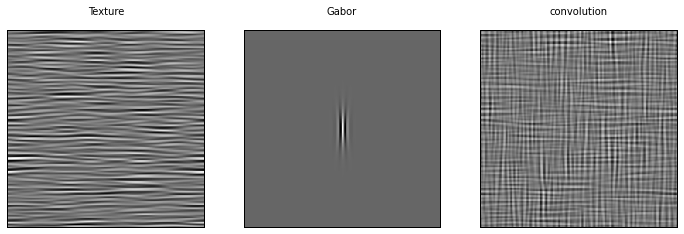

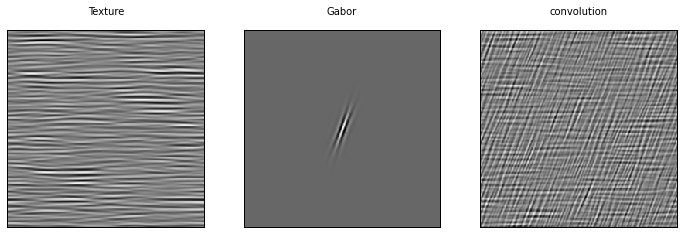

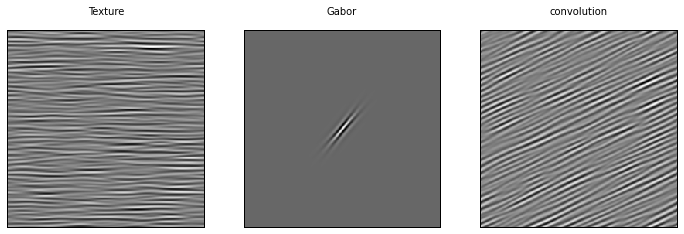

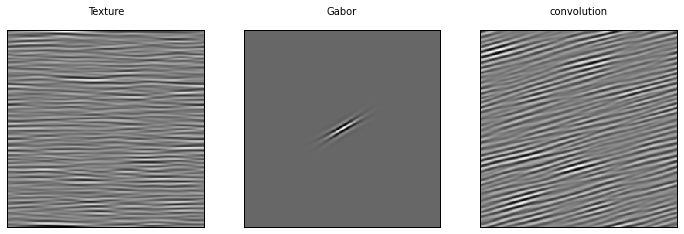

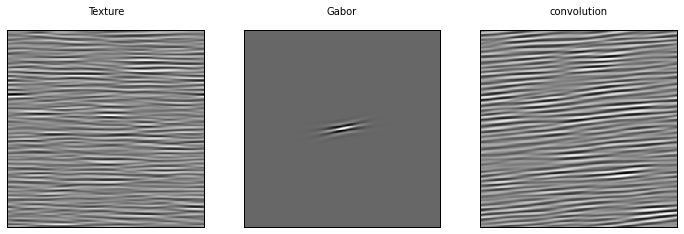

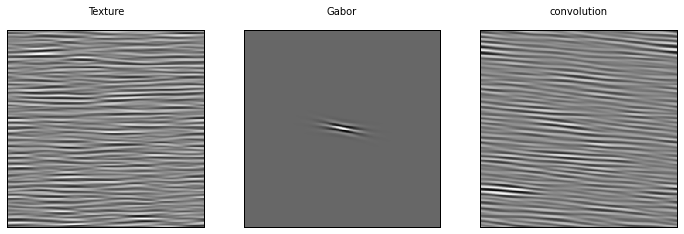

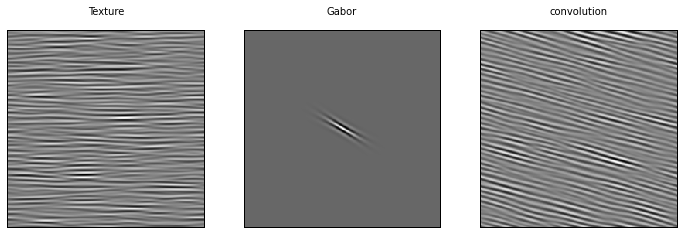

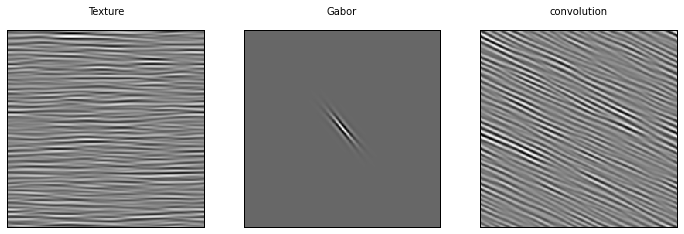

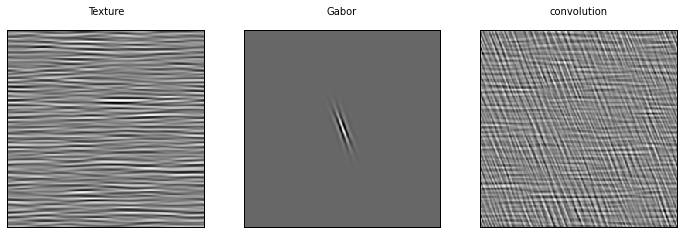

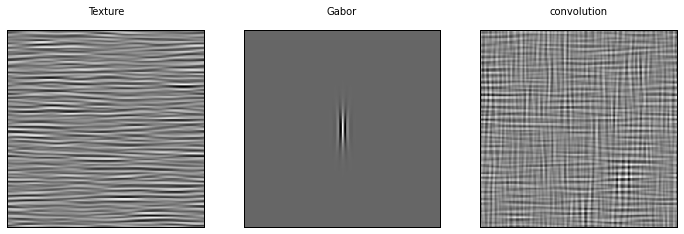

In [19]:
# images of convolutions with differents angles
N_theta=360
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, 10)

for i, theta0_ in enumerate(theta_0) :
    env_in = envelope_radial(im) * envelope_orientation(im)
    env_V1 = envelope_radial(im) * envelope_orientation(im, theta_0=theta0_)
    R = convolve(texture(env_in), impulse(env_V1))
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1), R], [u'Texture', u'Gabor', u'convolution'])):
        ax[i].matshow(f, cmap=plt.cm.gray)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

[Back to top](#SLIP)

## Whitening

In [20]:
print(im.whitening_filt.__doc__)


        Returns the average correlation filter in FT space.

        Computes the average power spectrum = FT of cross-correlation, the mean decorrelation
        is given for instance by (Attick, 92).

        


Testing the whitening strategy.

Generates 2 figures:

* one which compares Olshausen's formulation and the actual statistical measure
* one which shows the actual effect of whitening


In [21]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 16
figsize=(fig_width, .618*fig_width)
fopts = {'fontsize':18}

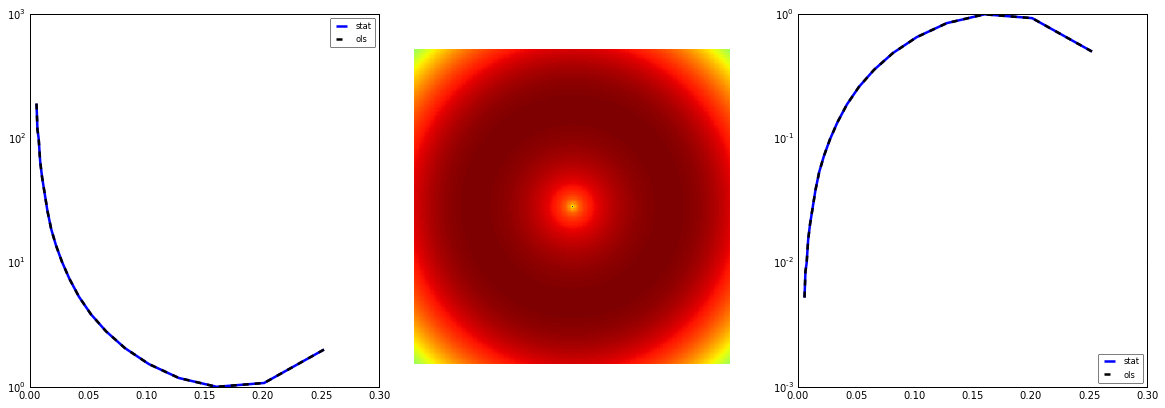

In [22]:
from SLIP import Image
im = Image('default_param.py')

def radial_frequency(F):
    N_f = 20 #F.shape[0]/2 # making an histogram with N_f bins
    f_bins = np.linspace(0., 0.5, N_f+1)
    f_bins = np.logspace(-2., 0, N_f+1, base=10)*0.5

    N_orientations = 24 # making an histogram with N_f bins
    theta_bins = np.linspace(0, np.pi, N_orientations, endpoint=False)

    F_rot = np.zeros((N_f, N_orientations))
    for i_theta in range(N_orientations):
        for i_f in range(N_f):
            f_slice = (f_bins[i_f] < im.f) *  ( im.f < f_bins[i_f+1])
            theta_slice = np.exp(np.cos(im.f_theta - theta_bins[i_theta])/(1.5*2*np.pi/N_orientations)**2)
            F_rot[i_f, i_theta] = (f_slice * theta_slice * F).sum()
            F_rot[i_f, i_theta] /= (f_slice * theta_slice).sum() # normalize by the integration area (numeric)
    if np.isnan(F_rot).any(): print('Beware of the NaNs!')
    F_rot /= F_rot.max()
    return f_bins, theta_bins, F_rot

def plot_whitening_filters():
    K = im.whitening_filt()
    f_bins, theta_bins, K_rot = radial_frequency(K)
    f_bins_m = .5*(f_bins[:1]+f_bins[1:])
    im.pe.learn = False
    K_ols = im.whitening_filt()
    f_bins, theta_bins, K_ols_rot = radial_frequency(K_ols)

    fig = plt.figure(figsize=(fig_width, fig_width/3))
    bord = 0.03
    a = plt.axes([bord, bord, 1/3.-bord,  1-bord])
    a.semilogy(f_bins_m, 1/K_rot.mean(axis=1),c='b', label='stat')
    a.semilogy(f_bins_m, 1/K_ols_rot.mean(axis=1), c='k', ls='--', label='ols')
    a.legend(loc="upper right")

    a = plt.axes([1/3.+bord, bord, 1/3.-2*bord , 1. -2*bord])
    a.matshow(np.log(K))
    a.axis('off')

    a = plt.axes([2/3.+bord, bord, 1/3.-bord, 1-bord])
    a.semilogy(f_bins_m, K_rot.mean(axis=1),c='b', label='stat')
    a.semilogy(f_bins_m, K_ols_rot.mean(axis=1), c='k', ls='--', label='ols')
    a.legend(loc="upper right")
    a.legend(loc="lower right")

plot_whitening_filters()


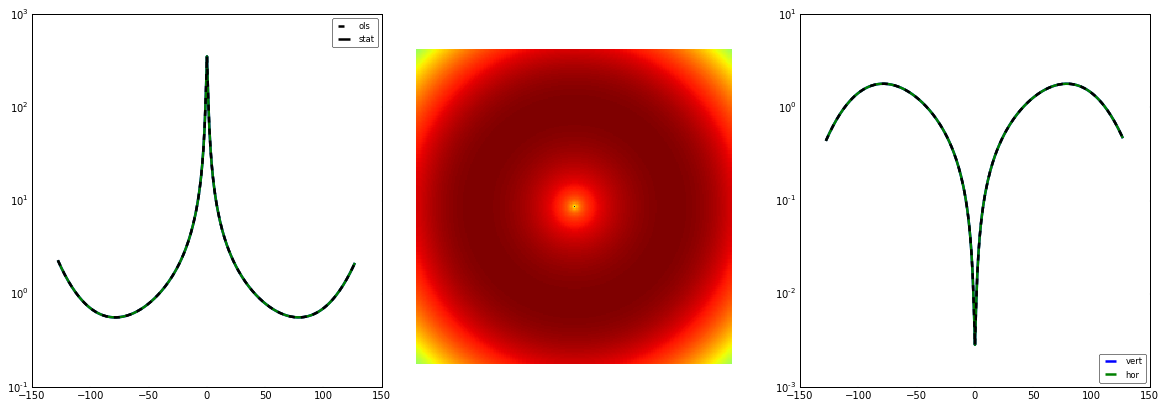

In [23]:
from SLIP import Image
im = Image('default_param.py')
im.pe.recompute = True
# TODO: know what N means : figure 3 ?

im.pe.learn = True
K = im.whitening_filt()
bord = .03

middle = np.ceil(K.shape[0]/2)
K_axis= np.arange(-middle,middle)
vec = .5 * (K[middle,:] + K[middle+1,:])
hor = .5 * (K[:,middle] + K[:,middle+1])

im.pe.learn = False
K_ols = im.whitening_filt()
#K_ols = im.olshausen_whitening_filt()
vec_ols = .5 * (K_ols[middle,:] + K_ols[middle+1,:])

#axes(rect, axisbg='w') where rect=[left, bottom, width, height] in
#normalized (0,1) units.  axisbg is the background color for the
#axis, default white

fig = plt.figure(figsize=(fig_width, fig_width/3))
a = plt.axes([bord, bord, 1/3.-bord,  1-bord])
a.semilogy(K_axis, 1/vec,c='b')
a.semilogy(K_axis, 1/hor,c='g')
a.semilogy(K_axis, 1/vec_ols, c='k', ls='--', label='ols')
a.semilogy([], c='k', ls='-', label='stat')
a.legend(loc="upper right")

a = plt.axes([1/3.+bord, bord, 1/3.-2*bord , 1. -2*bord])
a.matshow(np.log(K))
a.axis('off')

a = plt.axes([2/3.+bord, bord, 1/3.-bord, 1-bord])
a.semilogy(K_axis, vec,c='b')
a.semilogy(K_axis, hor,c='g')
a.semilogy(K_axis, vec_ols,c='k', ls='--')
a.semilogy([], c='b', label='vert')
a.semilogy([], c='g', label='hor')
a.legend(loc="lower right")

0%  100%
[]

 Testing that whitening effectively works... 
Title: 
  Started: 05/21/2015 13:41:49
  Finished: 05/21/2015 13:41:49
  Total time elapsed: 0.000 sec
Figure whitening
 Testing that whitening effectively works... 

0%  100%
[]


Title: 
  Started: 05/21/2015 13:41:50
  Finished: 05/21/2015 13:41:50
  Total time elapsed: 0.000 sec
Figure whitening
 Testing that whitening effectively works... 

0%  100%
[]


Title: 
  Started: 05/21/2015 13:41:50
  Finished: 05/21/2015 13:41:50
  Total time elapsed: 0.000 sec
Figure whitening


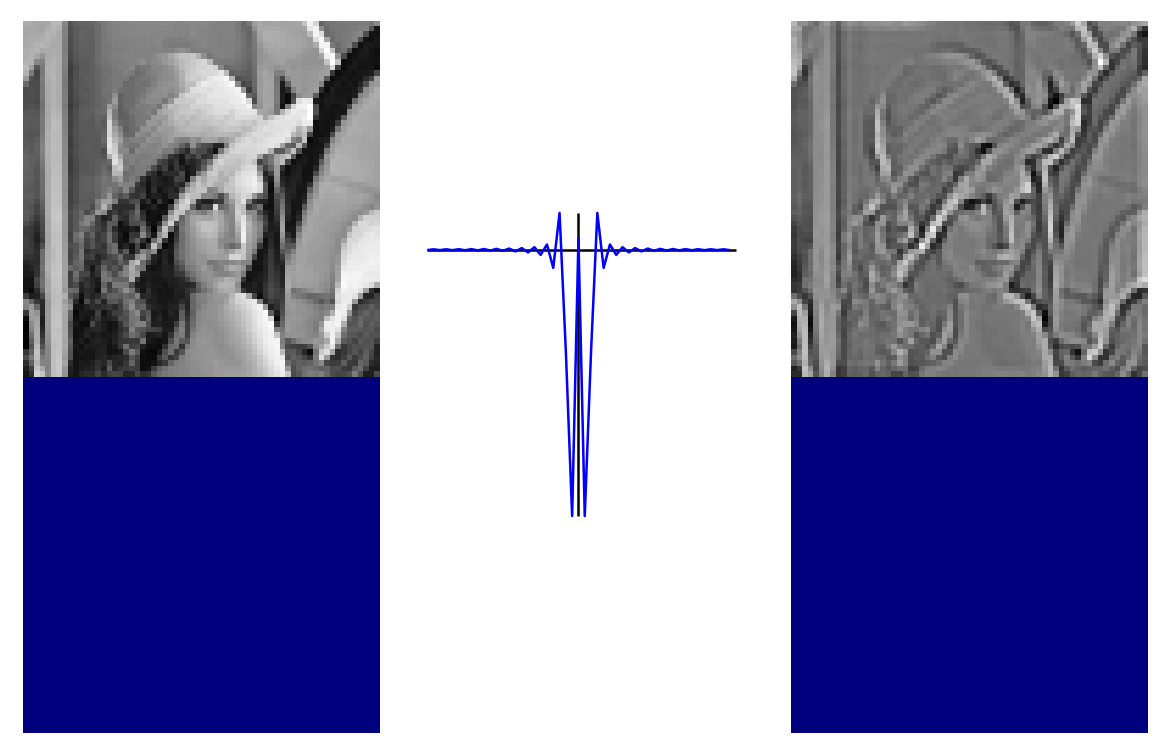

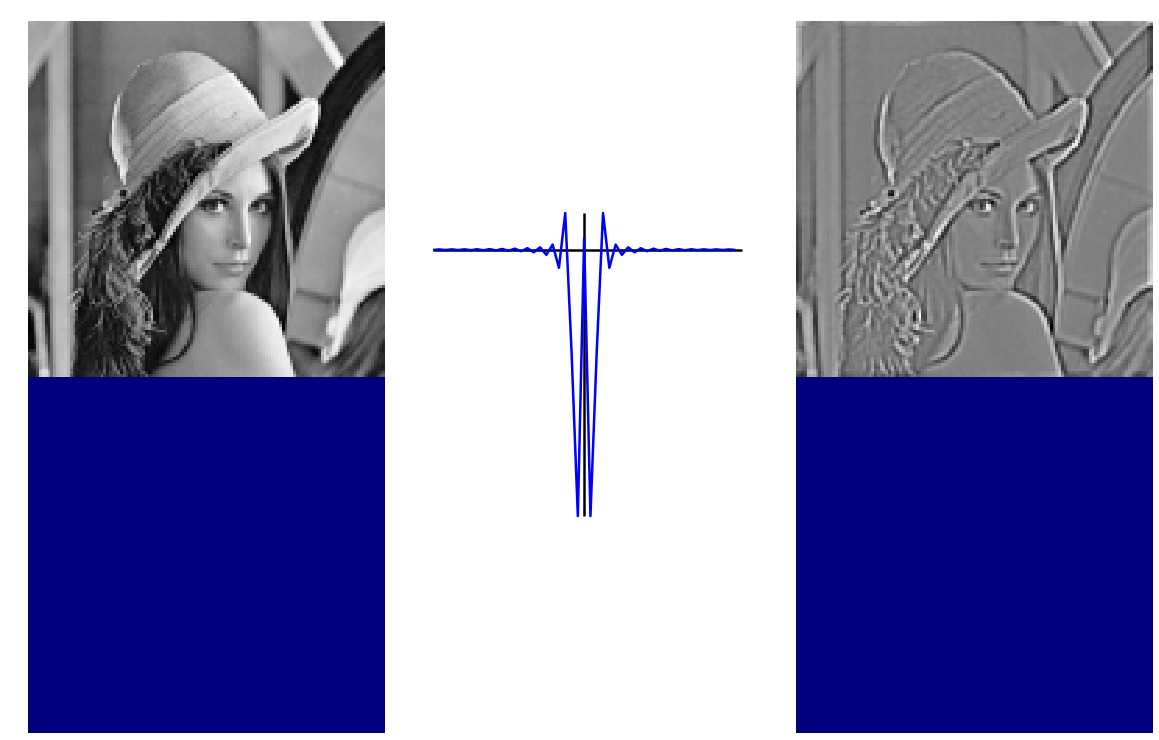

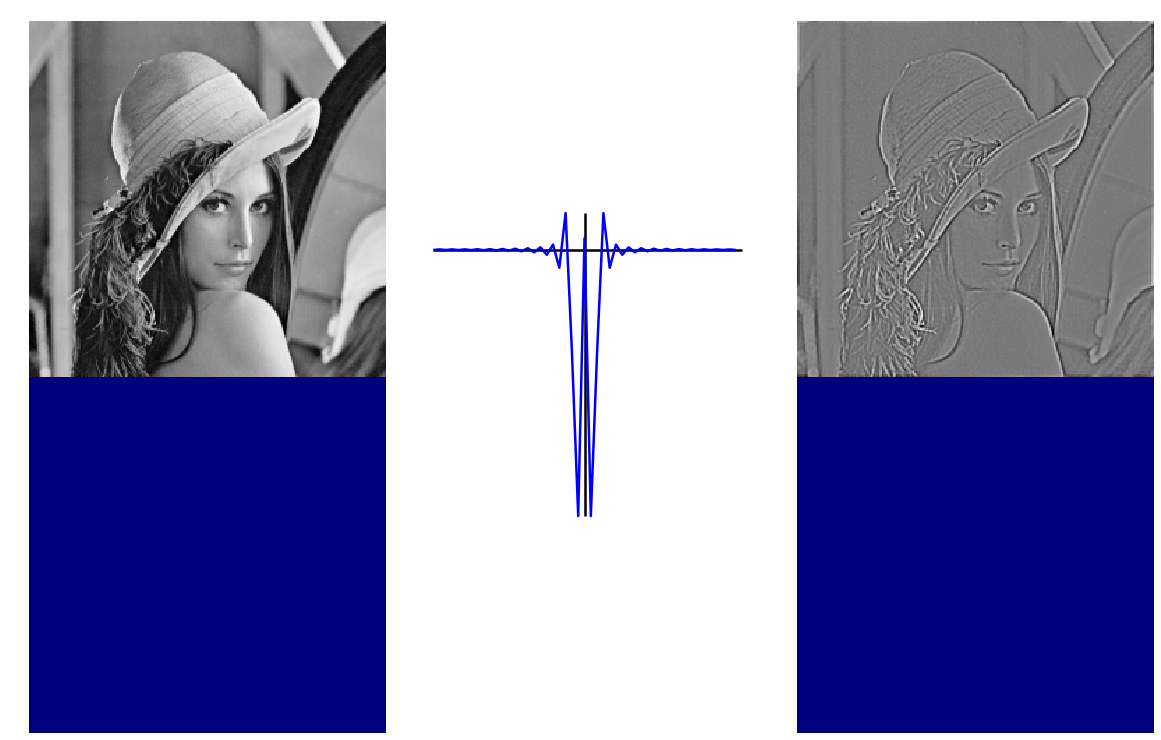

In [24]:
import pyprind 
for size in [64, 128, 256]:
    image = plt.imread('database/lena' +np.str(size) + '.png').mean(axis=-1)
    im = Image('default_param.py')
    print(' Testing that whitening effectively works... ')
    im.N_X = size
    im.N_Y = size
    im.init()
    xcorr, xcorr_white = np.zeros((im.N_X, im.N_Y)), np.zeros((im.N_X, im.N_Y))
    bar = pyprind.ProgBar(im.pe.white_n_learning, width=100)
    for i_learning in range(im.pe.white_n_learning):
        image_patch, filename, croparea = im.patch(im.pe.name_database, verbose=False)
        xcorr += im.coco(image_patch, image_patch)/im.pe.white_n_learning
        image_patch = im.whitening(image_patch)
        xcorr_white += im.coco(image_patch, image_patch)/im.pe.white_n_learning
        bar.update()
    print(bar)

    middle = np.ceil(K.shape[0]/2)
    print('Figure whitening')
    fig = plt.figure(figsize=(fig_width, .618*fig_width))
    bord = .03
    # top left
    a = plt.axes([0,  1/2., 1/3., 1/2.])
    a.matshow(image, cmap=plt.gray())
    a.axis('off')
    # top right
    a = plt.axes([2/3., 1/2., 1/3., 1/2.])
    white = im.whitening(image)
    a.matshow(white, cmap=plt.gray())
    a.axis('off')
    # middle
    a = plt.axes([1/3.+bord, .25, 1/3.-2*bord , 1/2.])
    impulse = np.zeros(image.shape)#(25,25))
    impulse[24,24] = 1
    K = im.whitening(impulse)[:49,:49]
    middle = np.ceil(K.shape[0]/2)
    K_middle = .5 * (K[middle,:] + K[middle+1,:])
    a.plot([24,24],[np.min(K_middle), np.max(K_middle)], c='k')
    a.plot([0, 49],[0,0], c='k')
    a.plot(K_middle, c='b')
    a.axis('off')
    # bottom left
    a = plt.axes([0,  0, 1/3., 1/2.])
    a.matshow(xcorr, cmap=plt.jet())#
    a.axis('off')
    #bottom right
    a = plt.axes([2/3., 0, 1/3., 1/2.])
    a.matshow(xcorr_white, cmap=plt.jet())
    a.axis('off')


The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


:AdjointLayout   [AdjointLayout]
   :Histogram   [Image]   (Frequency)
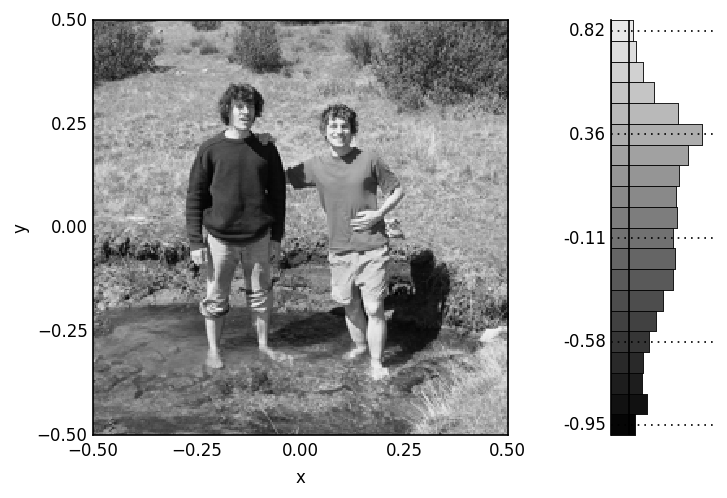

In [43]:
import holoviews as hv
%load_ext holoviews.ipython
%output size=150 dpi=120
%opts Image (cmap='gray')
import imageio
image = imageio.imread('database/yelmo256.png')[:,:,0]
hv.Image(im.normalize(image), value_dimensions=[hv.Dimension('Image', range=(-1,1))]).hist()

:AdjointLayout   [AdjointLayout]
   :Histogram   [z]   (Frequency)
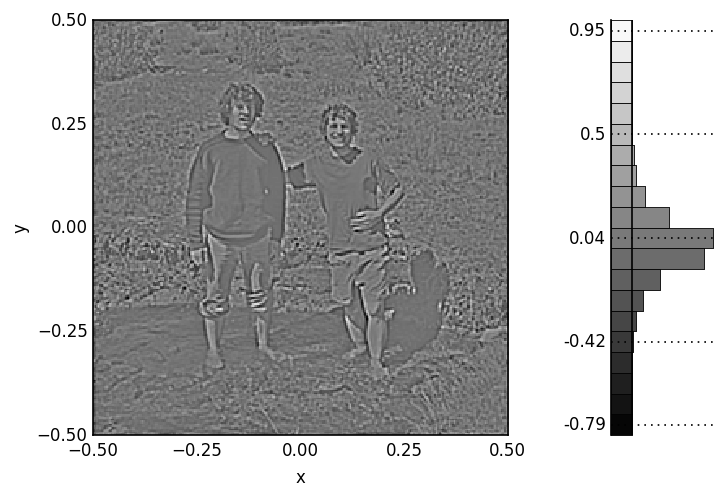

In [47]:
#! whitening to balance the energy of evey frequency band
white = im.whitening(image)
hv.Image(im.normalize(white)).hist()

:AdjointLayout   [AdjointLayout]
   :Histogram   [z]   (Frequency)
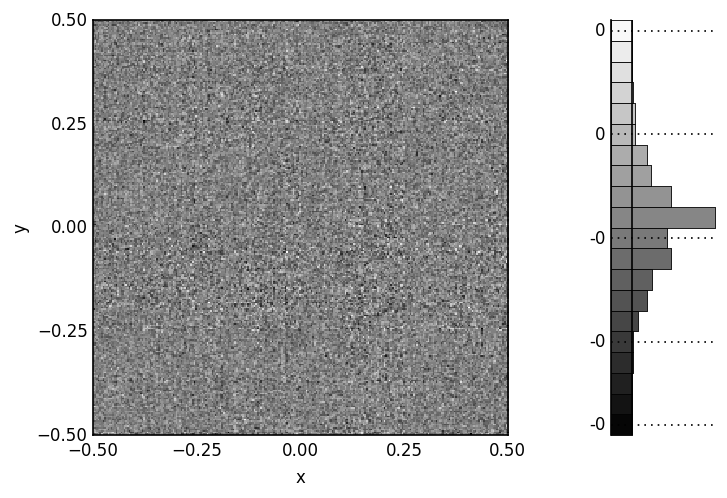

In [46]:
#! the filtering operation preserves infomation (none is lost...)
hv.Image(white - im.FTfilter(white, 1.)).hist()

Figure Atick


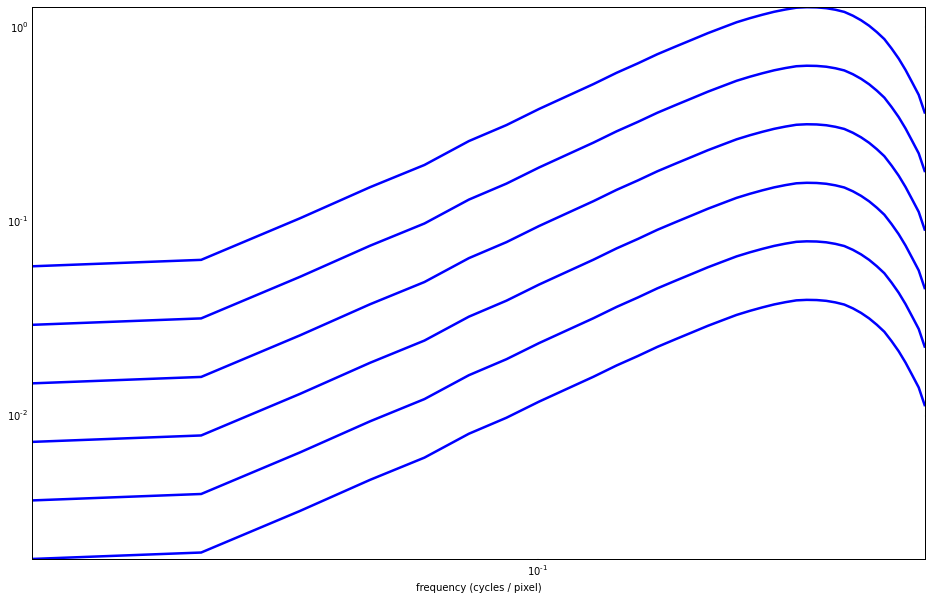

In [28]:
""" This is just to remember that we use a simpler fitering technique.

In the Attick LGN, the gain is changed according to an estimation of the SNR.

"""
print('Figure Atick')
image = plt.imread('database/lena256.png')[:,:,0]

contrasts = 1. / 2**np.arange(6)
freqs = np.linspace(0.,.49, 40)
size  = image.shape
x, y = np.mgrid[0:size[0],0:size[1]]

response = np.zeros((len(freqs), len(contrasts)))
for i_contrast, contrast in enumerate(contrasts):
    for i_freq, freq in enumerate(freqs):
        image = contrast * np.sin( 2* np.pi * x * freq)
        white = im.whitening(image)
        response[i_freq,i_contrast] = np.std(white)
response.shape

fig = plt.figure(figsize=(fig_width, 0.618*fig_width))
a = plt.subplot(111)
a.loglog(freqs,response,c='b')
plt.xlabel('frequency (cycles / pixel)')
_ = plt.axis('tight')

[Back to top](#SLIP)

## defining input image as Lena

In [29]:
image = plt.imread('database/lena256.png').mean(axis=-1)
print(image.mean(), image.std())
im = Image('default_param.py')
im.pe.N_X, im.pe.N_Y = image.shape
im.init()
image = im.normalize(image, center=False)
print(image.mean(), image.std())
image = im.normalize(image, center=True)
print(image.mean(), image.std())

0.501803 0.180984
0.539914 0.19473
-5.7742e-08 0.423248


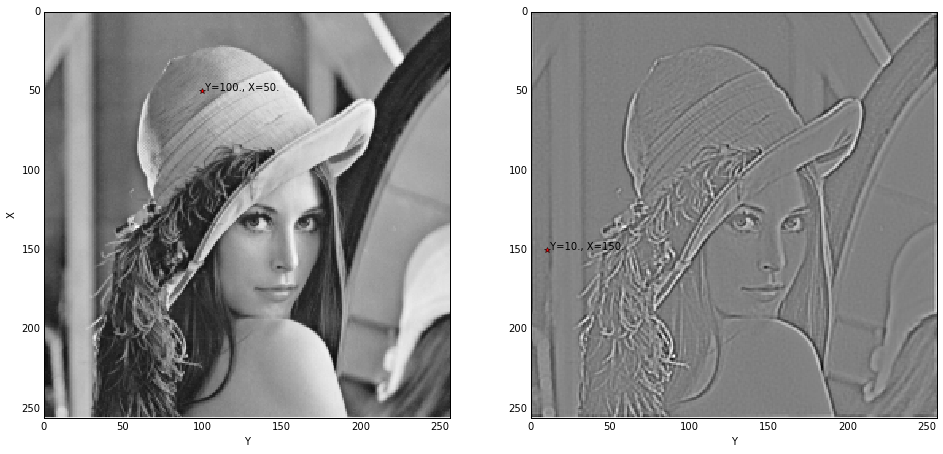

In [30]:
fig = plt.figure(figsize=figsize)
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
a1.imshow(im.normalize(image, center=True, use_max=True), **opts)
a1.set_xlabel('Y'), a1.set_ylabel('X')
a1.plot([100.], [50.], 'r*')
a1.text(100., 50., ' Y=100., X=50.')
a1.axis([0, image.shape[0], image.shape[1], 0])
a2.imshow(im.normalize(im.whitening(image), center=True, use_max=True), **opts)
a2.plot([10.], [150.], 'r*')
a2.text(10., 150., ' Y=10., X=150.')
a2.set_xlabel('Y')
v = a2.axis([0, image.shape[0], image.shape[1], 0])

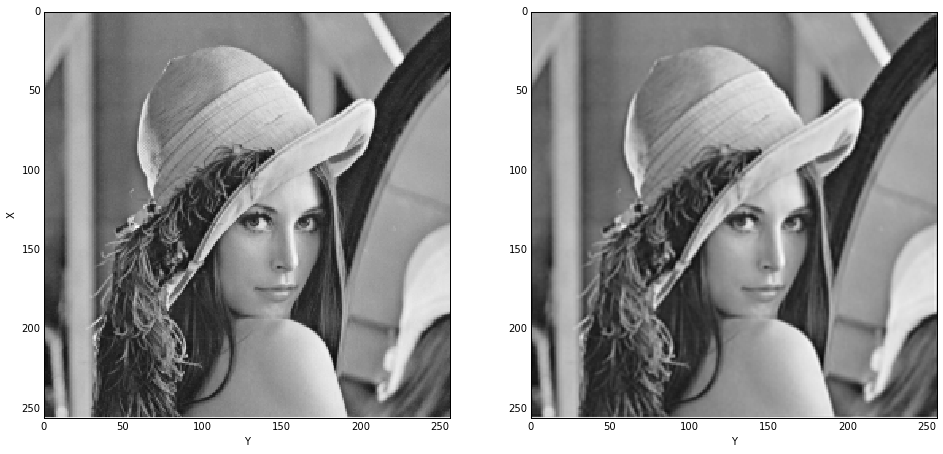

In [31]:
fig = plt.figure(figsize=figsize)
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
a1.imshow(im.normalize(image, center=True, use_max=True), **opts)
a1.set_xlabel('Y'), a1.set_ylabel('X')
a1.axis([0, image.shape[0], image.shape[1], 0])
a2.imshow(im.normalize(im.dewhitening(im.whitening(image)), center=True, use_max=True), **opts)
a2.set_xlabel('Y')
v = a2.axis([0, image.shape[0], image.shape[1], 0])

[Back to top](#SLIP)

## An application: statistics of natural images

In [32]:
import holoviews as hv
%load_ext holoviews.ipython
%output size=150 dpi=120

The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


:Layout
   .AdjointLayout.I  :AdjointLayout   [AdjointLayout]
      :Histogram   [z]   (Frequency)
   .AdjointLayout.II :AdjointLayout   [AdjointLayout]
      :Histogram   [z]   (Frequency)
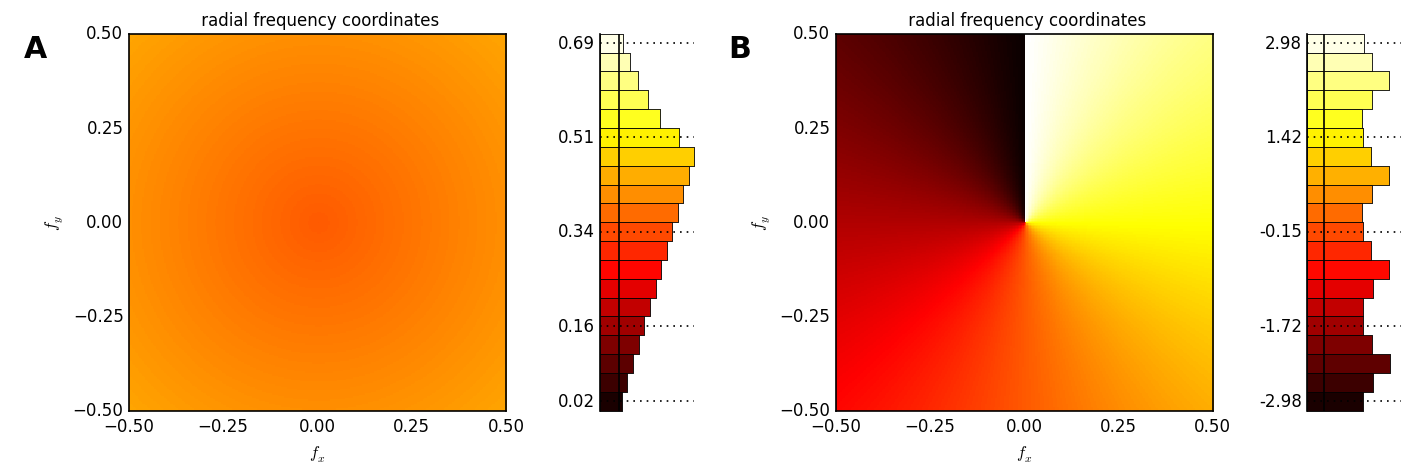

In [33]:
%opts Image (cmap='hot')
key_dims = [hv.Dimension('$f_x$', range=(0,1)), hv.Dimension('$f_y$', range=(0,1))]
s_f = hv.Image(im.f, group='radial frequency coordinates', key_dimensions=key_dims).hist()
s_theta = hv.Image(im.f_theta, group='radial frequency coordinates', key_dimensions=key_dims).hist()
s_f + s_theta

In [34]:
im = Image('default_param.py')
im.pe.datapath = '/Users/lolo/pool/science/PerrinetBednar15/database/'
name_database = 'serre07_targets'
imagelist = im.make_imagelist(name_database=name_database)

In [35]:
F = np.zeros_like(im.f_x)
for filename, croparea in imagelist:
    image, filename_, croparea_ = im.patch(name_database, filename=filename, croparea=croparea, center=False)
    F += np.fft.fftshift(np.absolute(np.fft.fftn(image))**2)
F /= F.max()

:AdjointLayout   [AdjointLayout]
   :Histogram   [z]   (Frequency)
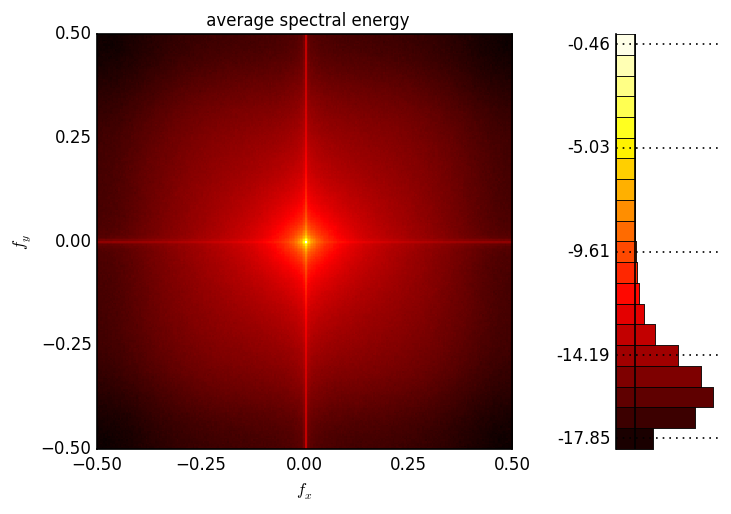

In [36]:
#fig, axs = plt.subplots(1, 1, figsize=(13, 13))
#axs.contourf(im.f_x[0, :], im.f_y[0, :], np.log(F).T, cmap=plt.hot())
#axs.pcolor(im.f_x, im.f_y, np.log(F), cmap=plt.hot())
#axs.axis('tight')
#axs.set_xlabel('radial frequency')
#_ = axs.set_ylabel('temporal frequency')
%opts Image (cmap='hot')
key_dims = [hv.Dimension('$f_x$', range=(0,1)), hv.Dimension('$f_y$', range=(0,1))]
hv.Image(np.log(F), group='average spectral energy', key_dimensions=key_dims).hist()

In [37]:
print('F is maximum at :', np.unravel_index(np.argmax(F), dims=F.shape), ' (we expected (', F.shape[0]/2, ', ', F.shape[0]/2, ') )')

F is maximum at : (128, 128)  (we expected ( 128.0 ,  128.0 ) )


We now try to fit a power-law to one slice:

In [38]:
!pip install lmfit

    100% |████████████████████████████████| 880kB 632kB/s 
  Running setup.py install for lmfit


In [39]:
from lmfit.models import PowerLawModel
mod = PowerLawModel()
valid = -(np.arange(F.shape[0])==F.shape[0]/2)
pars = mod.guess(F[valid, F.shape[0]/2], x=np.abs(im.f_x[valid, F.shape[0]/2]))
out  = mod.fit(F[valid, F.shape[0]/2], pars, x=np.abs(im.f_x[valid, F.shape[0]/2]))
print(out.fit_report(min_correl=0.25))

valid = -(np.arange(F.shape[1])==F.shape[1]/2)
pars = mod.guess(F[F.shape[1]/2, valid], x=np.abs(im.f_y[F.shape[1]/2, valid]))
out  = mod.fit(F[F.shape[1]/2, valid], pars, x=np.abs(im.f_y[F.shape[1]/2, valid]))
print(out.fit_report(min_correl=0.25))


[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 255
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
[[Variables]]
    exponent:   -1.88734512 +/- 0.007362 (0.39%) (init=-2.001716)
    amplitude:   7.0005e-07 +/- 2.82e-08 (4.03%) (init= 3.068444e-07)
[[Correlations]] (unreported correlations are <  0.250)
    C(exponent, amplitude)       =  0.999 
[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # function evals   = 16
    # data points      = 255
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
[[Variables]]
    exponent:   -2.03283804 +/- 0.004799 (0.24%) (init=-2.090675)
    amplitude:   1.2418e-07 +/- 3.27e-09 (2.63%) (init= 8.13825e-08)
[[Correlations]] (unreported correlations are <  0.250)
    C(exponent, amplitude)       =  0.999 


This proves that the spectrum of natural images falls as $\frac{1}{f^2}$. But is that true for all directions? Let's slice the Fourier spectrum along different orientations:

:AdjointLayout   [AdjointLayout]
   :Histogram   [z]   (Frequency)
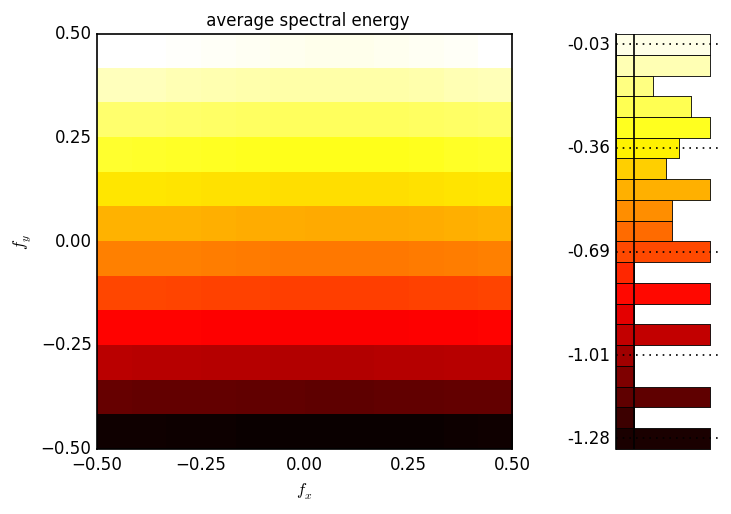

In [40]:
N_f = 12 #F.shape[0]/2 # making an histogram with N_f bins
f_bins = np.linspace(0., 0.5, N_f+1)
f_bins = np.logspace(-.5, 0, N_f+1, base=10)*0.5

N_orientations = 12 # making an histogram with N_f bins
theta_bins = np.linspace(0, np.pi, N_orientations, endpoint=False)

F_rot = np.zeros((N_f, N_orientations))
for i_theta in range(N_orientations):
    for i_f in range(N_f):
        f_slice = (f_bins[i_f] < im.f) *  ( im.f < f_bins[i_f+1])
        theta_slice = np.exp(np.cos(im.f_theta - theta_bins[i_theta])/(1.5*2*np.pi/N_orientations)**2)
        F_rot[i_f, i_theta] = (f_slice * theta_slice * F).sum()
        F_rot[i_f, i_theta] /= (f_slice * theta_slice).sum() # normalize by the integration area (numeric)
if np.isnan(F_rot).any(): print('Beware of the NaNs!')
F_rot /= F_rot.max()
hv.Image(np.log10(F_rot), group='average spectral energy', key_dimensions=key_dims).hist()

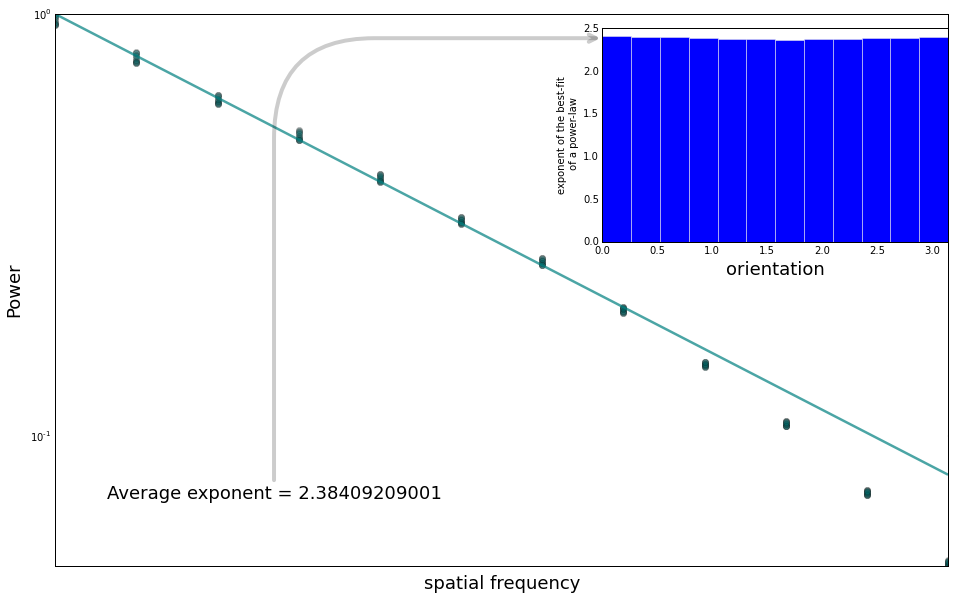

In [41]:
fig, axs = plt.subplots(1, 1, figsize=figsize) # fib
axs.set_color_cycle(np.array([[0., 1., 1.]]) * np.abs(f_bins)[:, np.newaxis])
fit_exp = np.zeros(N_orientations)
for i_theta in range(N_orientations): 
    axs.loglog((f_bins[:-1]+f_bins[1:])/2, F_rot[:, i_theta], 'o', alpha=.3)
    pars = mod.guess(F_rot[:, i_theta], x=(f_bins[:-1]+f_bins[1:])/2)
    out  = mod.fit(F_rot[:, i_theta], pars, x=(f_bins[:-1]+f_bins[1:])/2)
    fit_exp[i_theta] = -out.params.get('exponent').value
axs.axis('tight')
axs.set_xlabel('spatial frequency', **fopts)
_ = axs.set_ylabel('Power', **fopts)
inset = fig.add_axes([0.6, 0.58, .3, .3], axisbg='w')
inset.bar(theta_bins, fit_exp, width=theta_bins[1]-theta_bins[0])
inset.set_xlim((0, np.pi))
inset.set_xlabel('orientation', **fopts)
inset.set_ylabel('exponent of the best-fit \n of a power-law', fontsize=10)
fit = ((f_bins[:-1]+f_bins[1:])/2)**-fit_exp.mean()
axs.loglog((f_bins[:-1]+f_bins[1:])/2, fit/fit.max(), '-', alpha=.7)
_ = inset.annotate('Average exponent = ' + str(fit_exp.mean()), 
                   xy = (0., fit_exp.mean()), xytext = (-4.5, -3), 
                   arrowprops=dict(connectionstyle="angle,angleA=90,angleB=-180,rad=100", arrowstyle="->", lw=4, fc='b', ec='k', alpha=.2), **fopts)

Notice that the average exponent is sligthly different than the one obtained above when taking just one line or column of the spectrum, as slices in orientation are different (think of slicing a pie in a partition).

[Back to top](#SLIP)

## TODO

## more book keeping

In [42]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
21/05/2015 13:42:18

CPython 3.4.3
IPython 3.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.49)
system     : Darwin
release    : 14.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


[Back to top](#SLIP)